In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import corner
import numpy as np
import clmm
import matplotlib.pyplot as plt
from data_functions import *
from model_functions import _delta_sigma_4theta, _delta_sigma_const, _delta_sigma_excess, gamma_tangential_monopole
from clmm import Cosmology
import scipy
from scipy.optimize import minimize
from multiprocessing import Pool
import emcee
from IPython.display import display, Math


In [70]:
q=9/10
ell = (1-q**2)/(1+q**2)
r_ = np.logspace(-1,1,100)*0.7

mdelta = 2e14
delta_mdef = 200
cdelta = 3.89
z_cl   = 0.8

sigma_crit = 3.77988e+15

In [72]:
cosmo = Cosmology(H0=70.0, Omega_dm0=0.27 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

r_proj = np.linspace(0.1,1.0,1000)
sigma = clmm.compute_surface_density(r_proj, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model='nfw', massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)


In [73]:
rdelta = (mdelta/((4*np.pi/3)*cosmo.get_rho_m(z_cl)*delta_mdef))**(1/3)
rs=rdelta/cdelta

ds4theta, eta_func = _delta_sigma_4theta(ell, r_, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000)
dsconst, eta_func = _delta_sigma_const(ell, r_, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000)

In [74]:
# g_t_monopole = gamma_tangential_monopole(r_proj, mdelta, cdelta, z_cl, cosmo, hpmd='nfw')

In [75]:
indir = 'axis_ratio_9_10/'
gamma1 = np.hstack(np.load(f'catalogs/{indir}gamma1.npy') * -1)
gamma2 = np.hstack(np.load(f'catalogs/{indir}gamma2.npy') * -1)

gammat = np.hstack(np.load(f'catalogs/{indir}gamma_T.npy') * -1)
gammax = np.hstack(np.load(f'catalogs/{indir}gamma_X.npy') * -1)


x_arcsec = np.hstack(np.load(f'catalogs/{indir}x_arcsec.npy'))
y_arcsec = np.hstack(np.load(f'catalogs/{indir}y_arcsec.npy'))


In [76]:
Nbins = 15
arcsec_to_Mpc = 0.00588784182755241
r, rbin_edges, r_bins, r_inds = make_radial_bins(x_arcsec*arcsec_to_Mpc, y_arcsec*arcsec_to_Mpc, Nbins)
theta = calc_theta(x_arcsec, y_arcsec)

delta_sigmas_4theta = []
delta_sigmas_const = []
delta_sigmas_4theta_cross = []
delta_sigmas_const_cross = []
for i in range(Nbins):
    select = (r_inds == i) #& (r>=0.1)
    theta_i = theta[select]
    gamma1_i = gamma1[select]
    gamma2_i = gamma2[select]
    w_i, w1_i, w2_i = weights(sigma_crit, theta_i)
    DS4thetai = Delta_Sigma_4theta(w1_i, w2_i, gamma1_i, gamma2_i, theta_i, sigma_crit)
    DSconsti = Delta_Sigma_const(w_i, gamma1_i, sigma_crit)
    DS4thetacrossi = Delta_Sigma_4theta_cross(w1_i, w2_i, gamma1_i, gamma2_i, theta_i, sigma_crit)
    DSconstcrossi = Delta_Sigma_const_cross(w_i, gamma2_i, sigma_crit)
    delta_sigmas_4theta.append([np.mean(DS4thetai), np.std(DS4thetai)/np.sqrt(len(DS4thetai))])
    delta_sigmas_const.append([np.mean(DSconsti), np.std(DSconsti)/np.sqrt(len(DSconsti))])
    delta_sigmas_4theta_cross.append([np.mean(DS4thetacrossi), np.std(DS4thetacrossi)/np.sqrt(len(DS4thetacrossi))])
    delta_sigmas_const_cross.append([np.mean(DSconstcrossi), np.std(DSconstcrossi)/np.sqrt(len(DSconstcrossi))])

In [77]:
priors = np.array([[-1,1],[12,17],[0,1.5],[-15,0],[-15,0]])
ndim = len(priors)

In [78]:
def MLE(B,x,y1,dy1, y2, dy2) :
    ell_, log10_mdelta_, log10_cdelta_, ln_f1, ln_f2 = B
    mdelta_ = 10**log10_mdelta_
    cdelta_ = 10**log10_cdelta_
    yPred1 = _delta_sigma_4theta(ell_, x, mdelta_, cdelta_, z_cl, cosmo=cosmo, hpmd='nfw', sample_N=1000)[0]/0.7/1e12
    s1 = dy1**2 + yPred1**2*np.exp(2*ln_f1)
    yPred2 = _delta_sigma_const( ell_, x, mdelta_, cdelta_, z_cl, cosmo=cosmo, hpmd='nfw', sample_N=1000)[0]/0.7/1e12
    s2 = dy2**2 + yPred2**2*np.exp(2*ln_f2)
    negLL = - np.sum((y1-yPred1)**2/2/s1 + np.log(2*np.pi*s1)/2 + (y2-yPred2)**2/2/s2 + np.log(2*np.pi*s2)/2)
    return negLL

In [79]:
order = np.isfinite(r_bins) & (r_bins >= rs)

## Implementing emcee

In [91]:
nwalkers = 32
nsteps = int(1e4)

In [92]:
def log_prior(theta):
    if np.all([(priors[i,0] < theta[i] < priors[i,1]) for i in range(ndim)]) :
        return 0.0
    else :
        return -np.inf

In [93]:
def log_probability(theta, x, y1, dy1, y2, dy2) :
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else :
        return lp + MLE(theta, x, y1, dy1, y2, dy2)

In [94]:
pos = np.array([[priors[i,0] + np.ptp(priors[i])*np.random.random() for i in range(ndim)] for _ in range(nwalkers)])

with Pool() as pool :
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(r_bins[order], np.array(delta_sigmas_4theta)[:,0][order]/0.7/1e12, np.array(delta_sigmas_4theta)[:,1][order]/0.7/1e12, np.array(delta_sigmas_const)[:,0][order]/0.7/1e12, np.array(delta_sigmas_const)[:,1][order]/0.7/1e12), pool=pool)
    sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 10000/10000 [03:37<00:00, 46.06it/s]


In [95]:
# tau = sampler.get_autocorr_time()
# print(tau)

In [96]:
# flat_samples = np.concatenate(sampler.chain[:, :,:])
flat_samples = sampler.get_chain(discard=300, flat=True)

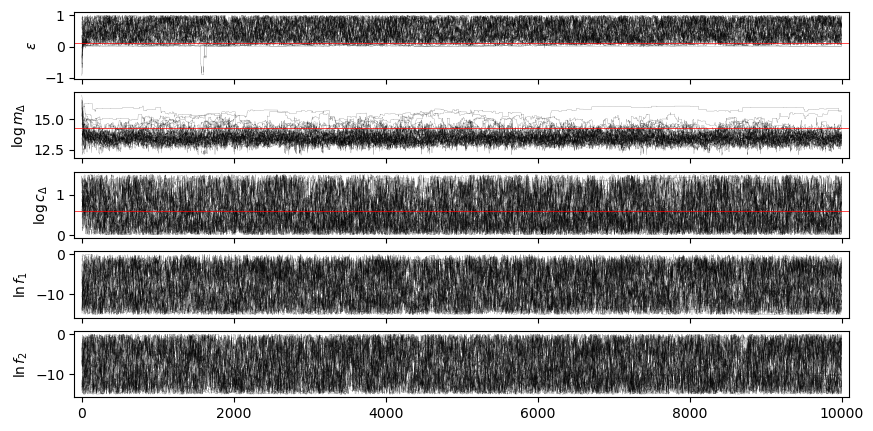

In [97]:
fig, axs = plt.subplots(ndim,1, figsize=(10,5), sharex=True);
[[axs[i].plot(sampler.chain[j,:,i], c='k', lw=0.1) for i in range(ndim)] for j in range(nwalkers)];
[ax.set_xlim(-100, nsteps+100) for ax in axs];

axs[0].axhline(ell, lw=0.5, c='r');
axs[1].axhline(np.log10(mdelta), lw=0.5, c='r');
axs[2].axhline(np.log10(cdelta), lw=0.5, c='r');

axs[0].set_ylabel(r'$\epsilon$');
axs[1].set_ylabel(r'$\log m_{\Delta}$');
axs[2].set_ylabel(r'$\log c_{\Delta}$');
axs[3].set_ylabel(r'$\ln f_1$');
axs[4].set_ylabel(r'$\ln f_2$');


In [98]:
labels = ['\epsilon', '\log M_\Delta', '\log c_\Delta', '\ln f_1', '\ln f_2']
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q_ = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q_[0], q_[1], labels[i])
    display(Math(txt))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [99]:
ps = [np.percentile(flat_samples[:,i], [16,50,84])[1] for i in range(ndim)]

In [100]:
ds4theta, eta_func = _delta_sigma_4theta(ps[0], r_, 10**ps[1], 10**ps[2], z_cl, cosmo, hpmd='nfw', sample_N=1000)
dsconst, eta_func = _delta_sigma_const(ps[0], r_, 10**ps[1], 10**ps[2], z_cl, cosmo, hpmd='nfw', sample_N=1000)

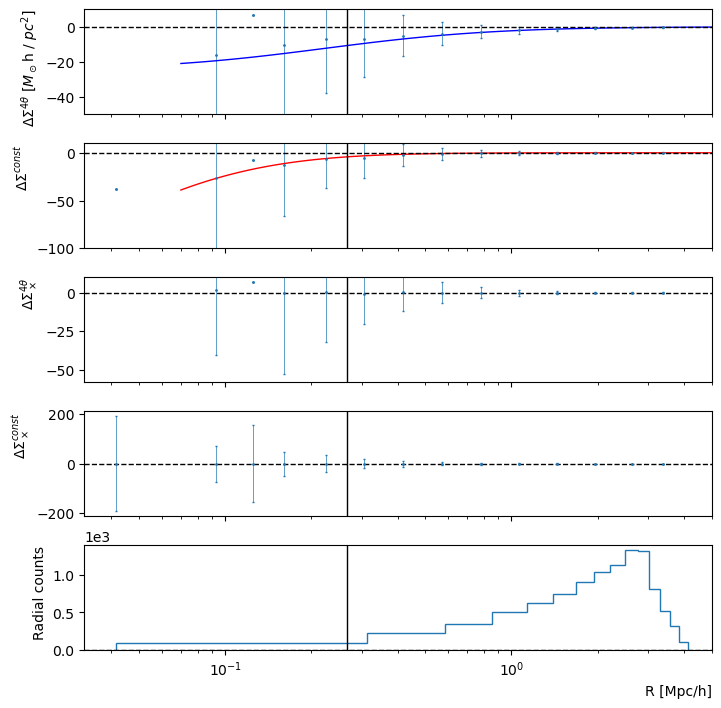

In [101]:
fig, axs = plt.subplots(5,1, figsize=(7,7), sharex=True);
plt.ticklabel_format(style='sci', axis='y', scilimits=(-2,2))
plt.tight_layout();

## Delta Sigma 4theta
axs[0].errorbar(r_bins, np.array(delta_sigmas_4theta)[:,0] / 0.7 / 1e12, yerr=np.array(delta_sigmas_4theta)[:,1] / 0.7 / 1e12, fmt='o', markersize=1, ls='none', elinewidth=0.5, capsize=1);
axs[0].plot(r_, ds4theta/0.7 / 1e12, 'b-', lw=1);
axs[0].set_ylabel(r'$\Delta \Sigma^{4\theta}$ [$M_\odot$h / $pc^2$]', loc='top');
axs[0].set_xscale('log');
axs[0].set_ylim(-50, 10);
axs[0].axhline(0, lw=1, ls='--', c='k');
axs[0].axvline(rs, lw=1, ls='-', c='k');

## Delta Sigma const
axs[1].errorbar(r_bins, np.array(delta_sigmas_const)[:,0] / 0.7 / 1e12, yerr=np.array(delta_sigmas_const)[:,1] / 0.7 / 1e12, fmt='o', markersize=1, ls='none', elinewidth=0.5, capsize=1);
axs[1].plot(r_, dsconst/0.7 / 1e12, 'r-', lw=1)
axs[1].set_ylabel(r'$\Delta \Sigma^{const}$', loc='top');
axs[1].set_xscale('log');
axs[1].set_ylim(-100, 10);
axs[1].axhline(0, lw=1, ls='--', c='k');
axs[1].axvline(rs, lw=1, ls='-', c='k');

## Delta Sigma 4theta X
axs[2].errorbar(r_bins, np.array(delta_sigmas_4theta_cross)[:,0] / 0.7 / 1e12, yerr=np.array(delta_sigmas_4theta_cross)[:,1] / 0.7 / 1e12, fmt='o', markersize=1, ls='none', elinewidth=0.5, capsize=1);
axs[2].set_ylabel(r'$\Delta \Sigma^{4\theta}_\times$', loc='top');
axs[2].set_xscale('log');
axs[2].set_ylim(top=10);
axs[2].axhline(0, lw=1, ls='--', c='k');
axs[2].axvline(rs, lw=1, ls='-', c='k');

## Delta Sigma const X
axs[3].errorbar(r_bins, np.array(delta_sigmas_const_cross)[:,0] / 0.7 / 1e12, yerr=np.array(delta_sigmas_const_cross)[:,1] / 0.7 / 1e12, fmt='o', markersize=1, ls='none', elinewidth=0.5, capsize=1);
axs[3].set_ylabel(r'$\Delta \Sigma^{const}_\times$', loc='top');
axs[3].set_xscale('log');
axs[3].axhline(0, lw=1, ls='--', c='k');
axs[3].axvline(rs, lw=1, ls='-', c='k');

axs[4].hist(r, bins=Nbins, histtype='step');
axs[4].axhline(0, lw=1, ls='--', c='k');
axs[4].axvline(rs, lw=1, ls='-', c='k');
axs[4].set_ylabel('Radial counts', loc='top');
axs[4].set_xlabel('R [Mpc/h]', loc='right');
axs[4].set_xlim(right=5);

## Calculate monopole term

In [63]:
from scipy.stats import binned_statistic

In [64]:
gammat_mono = -2*binned_statistic(r, gamma1*np.cos(2*theta), statistic='mean', bins=rbin_edges)[0]

In [65]:
DS_model = _delta_sigma_excess(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000, delta_mdef=200)

In [66]:
eta_0_arr = np.gradient(np.log(DS_model),r)*r


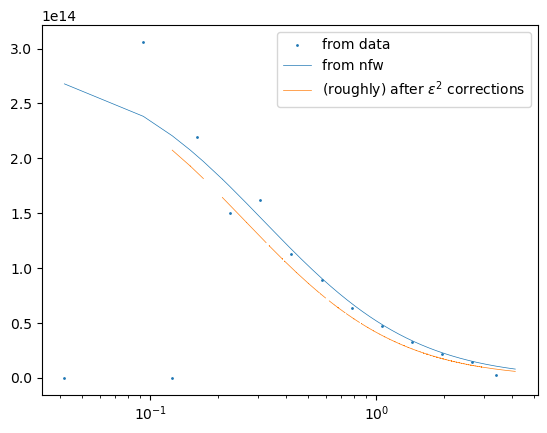

In [67]:
r_order = np.argsort(r)
plt.scatter(r_bins, abs(gammat_mono*sigma_crit), s=1, label='from data', zorder=np.inf);
plt.plot(r[r_order], abs(DS_model[r_order]), lw=0.5, label='from nfw');
plt.plot(r[r_order], abs(DS_model[r_order]/q**(eta_0_arr[r_order]/2)), lw=0.5, label='(roughly) after $\epsilon^2$ corrections');
plt.xscale('log');
plt.legend();